- movies: movement of particles with arrows AND heat bars with colours according to direction of motion
- in header of graph: parameter display for velocity and noise
- cos(theta)/|cos(theta)| - for 1 timeframe for all particles --> should be close to 1 and plot this against time
- evaluate the behaviour of theta-stuff with time

In [1]:
#read files in the "output" folder and generate movie and diagrams to each output file in the folder "evaluation"

#import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.cm as cm

In [ ]:
#change to current directory
path = "../output/"

pathdata = "out_agntno_300_noistr_1.000000.txt"
time, agent_index, position_x, position_y, angles = np.loadtxt(path+pathdata,float,skiprows=9,unpack=True)

In [ ]:
#extract input parameters from the txt file
lines = np.loadtxt(path+pathdata, dtype=str, skiprows=1, max_rows=8, unpack = True)
for l in lines:
    exec(l)

#rename agent_number as N
N = agent_number

#movie
fig = plt.figure()
positions = plt.scatter(position_x[0:N],position_y[0:N],c=cm.jet(angles[0:N]/(2*np.pi)))
plt.title("N = {}, velocity = {}, noise = {}, radius = {}".format(N,velocity,noise_strength,neighborhood_radius))
text = plt.text(0,-2,"Time: 0")

#update function for movie
def update(i,positions,text):
    #update(time, any further things which should be updated in animation)
    positions.set_offsets(np.transpose([position_x[i*N:(i+1)*N],position_y[i*N:(i+1)*N]]))
    positions.set_color(c=cm.jet(angles[i*N:(i+1)*N]/(2*np.pi)))
    text.set_text("Time: {:.1f}".format(time[i*N]))
    return positions,text

#generate a movie
animation = anim.FuncAnimation(fig,update,np.size(time)//N,fargs=(positions,text),interval=100,blit=False,repeat=False)

#for MP4 files
Writer = anim.FFMpegWriter(fps=10, bitrate=1800)
plt.rcParams["animation.ffmpeg_path"] = "C:/Users/moniq/Dropbox/MA_1/MA_2_Physics-of-Life/project/evaluation/FFmpeg/bin/ffmpeg.exe"

#save movie
animation.save(pathdata+".mp4", writer=Writer)
plt.show()

In [ ]:
#calculations
polarisation = []
meanangle = []

for i in range (np.size(time)//N):
    theta = angles[i*N:(i+1)*N] #in radians for cos functions
    mean_theta = np.mean(theta)
    polarisation.append((1/N) * np.abs(np.sum(theta))) #polarisation per frame
    meanangle.append(np.cos(np.mean(theta)))

#frames
xdata = list(range(1,(np.size(time)//N)+1))

In [ ]:
#meanangle
plt.figure()
plt.plot(xdata,meanangle)
plt.xlabel('frame')
plt.ylabel(r'cos(<$\Theta$>)')
plt.grid()
plt.savefig(pathdata+'meanangle.png')
plt.show()

In [ ]:
#polarisation
plt.figure()
plt.plot(xdata,)
plt.xlabel('frame')
plt.ylabel(r'1/N $\sum$(<$\Theta$>)')
plt.grid()
plt.savefig(pathdata+'polarisation.png')
plt.show()

In [ ]:
sigma = N/(box_size)**2  #particle density
polarisat = np.mean(polarisation) # polarisation

script for all exe files in the folder "output"

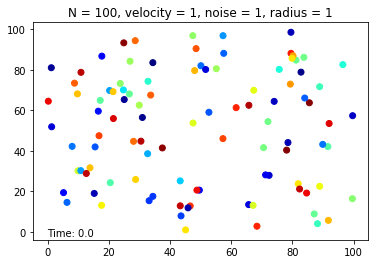

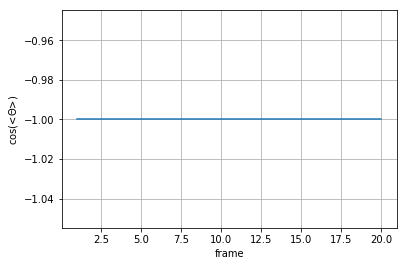

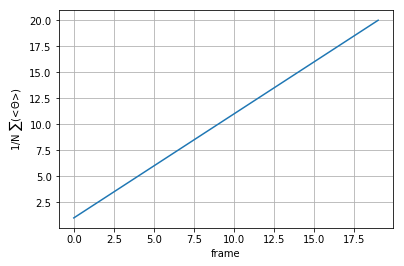

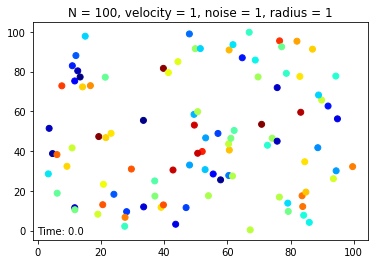

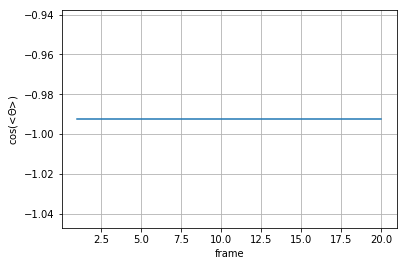

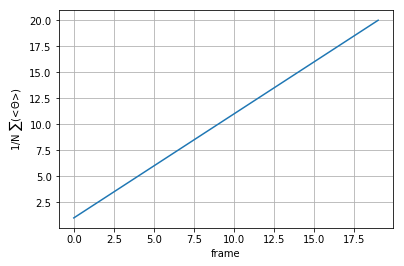

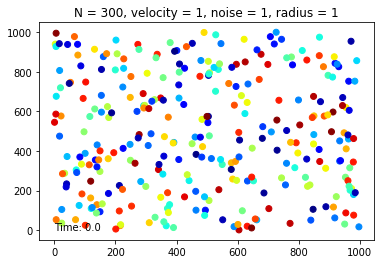

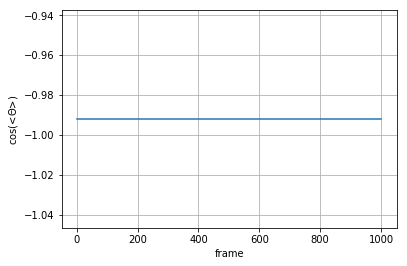

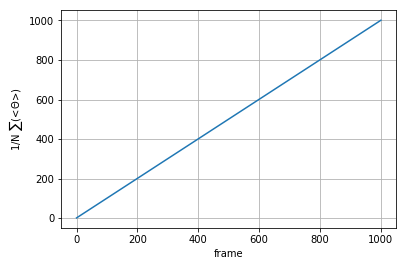

In [7]:
#change to current directory
path = "../output/"

#evaluate all .text files in folder
import glob
pathdata = glob.glob(path+"*.txt")

#output
rho = []
polarisat = []

for d in list(range(np.size(pathdata))):
    time, agent_index, position_x, position_y, angles = np.loadtxt(path+pathdata[d],float,skiprows=9,unpack=True)
    #extract input parameters from the txt file
    lines = np.loadtxt(path+pathdata[d], dtype=str, skiprows=1, max_rows=8, unpack = True)
    for l in lines:
        exec(l)
    #rename agent_number as N
    N = agent_number
    #movie
    fig = plt.figure()
    positions = plt.scatter(position_x[0:N],position_y[0:N],c=cm.jet(angles[0:N]/(2*np.pi)))
    plt.title("N = {}, velocity = {}, noise = {}, radius = {}".format(N,velocity,noise_strength,neighborhood_radius))
    text = plt.text(0,-2,"Time: 0")
    #update function for movie
    def update(i,positions,text):
        #update(time, any further things which should be updated in animation)
        positions.set_offsets(np.transpose([position_x[i*N:(i+1)*N],position_y[i*N:(i+1)*N]]))
        positions.set_color(c=cm.jet(angles[i*N:(i+1)*N]/(2*np.pi)))
        text.set_text("Time: {:.1f}".format(time[i*N]))
        return positions,text
    #generate a movie
    animation = anim.FuncAnimation(fig,update,np.size(time)//N,fargs=(positions,text),interval=100,blit=False,repeat=False)
    #for MP4 files
    Writer = anim.FFMpegWriter(fps=10, bitrate=1800)
    plt.rcParams["animation.ffmpeg_path"] = "C:/Users/moniq/Dropbox/MA_1/MA_2_Physics-of-Life/project/evaluation/FFmpeg/bin/ffmpeg.exe"
    #save movie
    animation.save(pathdata[d]+".mp4", writer=Writer)
    plt.show()
    #calculations
    polarisation = []
    meanangle = []
    for i in range (np.size(time)//N):
        theta = angles[i*N:(i+1)*N] #in radians for cos functions
        mean_theta = np.mean(theta)
        polarisation.append((1/N) * np.abs(np.sum(theta))) #polarisation per frame
        meanangle.append(np.cos(np.mean(theta)))
    #frames
    xdata = list(range(1,(np.size(time)//N)+1))
    #meanangle
    plt.figure()
    plt.plot(xdata,meanangle)
    plt.xlabel('frame')
    plt.ylabel(r'cos(<$\Theta$>)')
    plt.grid()
    plt.savefig(pathdata[d]+'meanangle.png')
    plt.show()
    #polarisation
    plt.figure()
    plt.plot(xdata,polarisation)
    plt.xlabel('frame')
    plt.ylabel(r'1/N $\sum$(<$\Theta$>)')
    plt.grid()
    plt.savefig(pathdata[d]+'polarisation.png')
    plt.show()
    #further calculations
    rho.append(N/(box_size)**2)  #particle density
    polarisat.append(np.mean(polarisation)) # polarisation

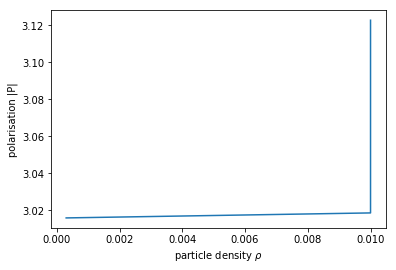

In [11]:
#rho-polarisation-diagram
plt.figure()
plt.plot(rho,polarisat)
plt.xlabel(r'particle density $\rho$')
plt.ylabel('polarisation |P|')
plt.savefig('density_polarisation.png')
plt.show()